# EDA - 1
Explore the relationship between the _sentiment in comments_ and _review scores in different aspects like description accuracy, clealiness, location, communcation, etc._

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import geopandas as gpd

In [30]:
%matplotlib inline

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
df = pd.read_csv('../../Datasets/cleaned_senti_reviews.csv').iloc[:,1:]
df.head()

,Unnamed: 0.1,reviewer_id,listing_id,date,reviewer_name,comments,name,description,neighborhood_overview,host_id,...,review_scores_value,instant_bookable,calculated_host_listings_count,reviews_per_month,polarity_score,sentiment,nearby_sites_rating,nearest_station_dist,nearest_site_dist,nearest_site_rating
0,0,8557223,49091,2013-10-21,Jared,Fran was absolutely gracious and welcoming. Ma...,COZICOMFORT LONG TERM STAY ROOM 2,This is Room No. 2.(available after Jan 15 201...,NaN,266763,...,8.0,f,2,0.02,0.9615,pos,0.995731,0.617762,4.295315,4.595264
1,1,1356099,50646,2014-04-18,James,A comfortable room in a smart condo developmen...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,9.0,f,1,0.30,0.9484,pos,1.269606,0.399696,2.039236,4.654423
2,2,15222393,50646,2014-06-05,Welli,Stayed over at Sujatha's house for 3 good nigh...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,9.0,f,1,0.30,0.9879,pos,1.269606,0.399696,2.039236,4.654423
3,3,5543172,50646,2014-07-02,Cyril,It's been a lovely stay at Sujatha's. The room...,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,9.0,f,1,0.30,0.9627,pos,1.269606,0.399696,2.039236,4.654423
4,4,817532,50646,2014-07-08,Jake,"We had a great experience. A nice place, an am...",Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,227796,...,9.0,f,1,0.30,0.9274,pos,1.269606,0.399696,2.039236,4.654423


In [10]:
df = df.rename(columns = {'polarity_score': 'senti_score'})

In [11]:
df.columns

Index(['Unnamed: 0.1', 'reviewer_id', 'listing_id', 'date', 'reviewer_name',
       'comments', 'name', 'description', 'neighborhood_overview', 'host_id',
       'host_since', 'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
     

In [12]:
# The sentiment scores are acquired from the previous data preparation step.
df_review = df[['senti_score','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value']]

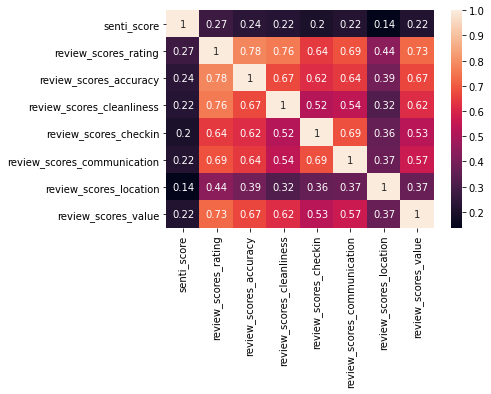

In [13]:
corrMatrix = df_review.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### It can be seen that there exists moderate correlation between sentiment score in comments and review scores, especially the review_score_rating.
The review score rating is presumed to be the overall score for the house by that reviewer. <br>
To make a more rigorous evaluation, we regressed the sentiment score on all other review scores.

In [14]:
# Utility method for linear regression and its summary.
def linear_model(X,y):
    import statsmodels.api as sm
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())
    print("R Squared:",est2.rsquared)

In [15]:
X = df_review.dropna().drop(['senti_score'],axis=1)
y = df_review.dropna()['senti_score']
linear_model(X,y)

                            OLS Regression Results                            
Dep. Variable:            senti_score   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     1588.
Date:                Tue, 20 Apr 2021   Prob (F-statistic):               0.00
Time:                        22:23:08   Log-Likelihood:                -28999.
No. Observations:              130603   AIC:                         5.801e+04
Df Residuals:                  130595   BIC:                         5.809e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

As can be seen from above, except review_score_value, **all other review scores are significantly correlated with sentiment scores**, which means all these factors **affect much** in user reviews.

#### Now we explore the correlation between review_location_score and nearby sites

In [16]:
# Extract the relevant features
df_location = df[['review_scores_location','nearby_sites_rating', 'nearest_station_dist', 'nearest_site_dist',
       'nearest_site_rating']]

`nearby_sites_rating` means the weighted average rating score for the nearest 3 sites; `nearest_site_dist` means the distance to the nesrest popular site; `nearest_site_rating` means the rating for the nearest site; `nearest_station_dist` means the distance to the nearest MRT station.

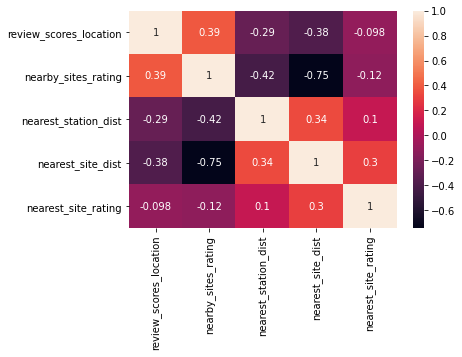

In [17]:
corrMatrix = df_location.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

As can be observed from above the `nearby site rating` is closely related to the `review score location`. And `review score location`is also negatively correlated with the `nearest site distance` and `nearest_station_dist`, which is reasonable because the further a location is to a station or a popular site, the worse its location tends to be.<br>

The conclusion is that among the factors that affect user review sentiments, `review_scores_location` plays **an insignificant role**, which means customers are **not so focused on** the location of the hotel. Specifically, the `location score` is **closely related to** the distance to nearby sites and MRT stations and the popularity of the sites.

# EDA - 5

Relationship between `Price`,`review_scores`, `sentiment_score` and `Neighbourhood_cleansed`, where `Neighbourhood_cleansed` means the summarized and cleansed version of the original neighborhood name.

In [18]:
# Transform the price attribute to numeric.
df.price = df.price.apply(lambda x:float(x.strip('$').replace(',',''))) 

In [19]:
df.price.describe()

count    130633.000000
mean        133.227316
std         134.397595
min           0.000000
25%          62.000000
50%         100.000000
75%         169.000000
max        9999.000000
Name: price, dtype: float64

As we can see from above, there are some **outliers** in price. Thus we decided to keep 99.5% of the price data for the sake of analysis.

In [20]:
df[df.price > df.price.quantile(0.995)].drop_duplicates(['listing_id']).price.describe()

count      86.000000
mean     1328.162791
std      1650.753324
min       601.000000
25%       664.750000
50%       785.000000
75%      1137.500000
max      9999.000000
Name: price, dtype: float64

In [21]:
df_cut = df[df.price <= df.price.quantile(0.995)]

In [41]:
df_cut.shape

(130018, 62)

In [22]:
# Extract the useful features.
df_price = df_cut[['price','senti_score','review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','neighbourhood_cleansed']]

In [23]:
keep_nbrhood = df_price.neighbourhood_cleansed.value_counts()[:-5]
df_price_keep = df_price[[x in keep_nbrhood for x in df_price.neighbourhood_cleansed]]

In [24]:
# Group all duplicate listings and keep their mean price.
df_price_nbr = df_price_keep.groupby(['neighbourhood_cleansed']).mean()

In [28]:
df_price_nbr['price'].mean()

115.54031216637524

In [31]:
df_price_nbr.sort_values(['price'],ascending=False)[:3]

,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,,
Museum,331.883162,0.824624,95.561512,9.697595,9.666667,9.870790,9.741581,9.928522,9.344330
Southern Islands,221.177632,0.817476,96.934211,9.782895,9.842105,9.743421,9.802632,9.421053,9.348684
Orchard,212.228146,0.695625,89.349667,9.070169,8.821639,9.386907,9.451980,9.688358,8.902783


In [32]:
df_price_nbr.sort_values(['price'],ascending=True)[:3]

,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,,
Sungei Kadut,49.028662,0.762738,94.270701,9.652866,10.000000,10.000000,9.917197,8.000000,9.605096
Sengkang,50.222638,0.798954,94.731525,9.921422,9.666978,9.788587,9.942937,8.889616,9.461179
Yishun,59.855000,0.763592,93.161667,9.476667,9.343333,9.711667,9.493333,8.716667,9.193333


In [33]:
df_price_nbr.sort_values(['review_scores_rating'],ascending=False)[:3]

,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,,
Southern Islands,221.177632,0.817476,96.934211,9.782895,9.842105,9.743421,9.802632,9.421053,9.348684
Museum,331.883162,0.824624,95.561512,9.697595,9.666667,9.870790,9.741581,9.928522,9.344330
Pasir Ris,82.336264,0.787901,95.038095,9.782991,9.679853,9.852639,9.872434,9.348974,9.539589


In [34]:
df_price_nbr.sort_values(['review_scores_rating'],ascending=True)[:3]

,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
neighbourhood_cleansed,,,,,,,,,
Orchard,212.228146,0.695625,89.349667,9.070169,8.821639,9.386907,9.451980,9.688358,8.902783
River Valley,144.655724,0.723342,89.512354,9.191045,9.091637,9.430692,9.431388,9.327572,8.916599
Tanglin,145.102414,0.753698,90.491587,9.285784,8.900024,9.727627,9.673250,9.278469,9.057547


Now we plot the price and relevant measures on the map.

In [35]:
# import our image 
singapore_img = mpimg.imread('../Pictures/Sgshape.png')

In [44]:
# plot the data
def plotmap(df, attr):
    ax = df.plot(
        kind="scatter", 
        x="longitude", 
        y="latitude", 
        figsize=(20,14),
        c=attr, 
        cmap=plt.get_cmap("YlGnBu"),
        colorbar=True, 
        alpha=0.4,
    )
    plt.imshow(singapore_img, extent=[103.5,104,1.15, 1.50], alpha=0.5)            

    plt.ylabel("Latitude", fontsize=20)
    plt.xlabel("Longitude", fontsize=20)

    plt.ylim(1.15, 1.50)
    plt.xlim(103.5, 104)
    plt.title('Price Variations with Locations', fontsize = 20)
    plt.show()

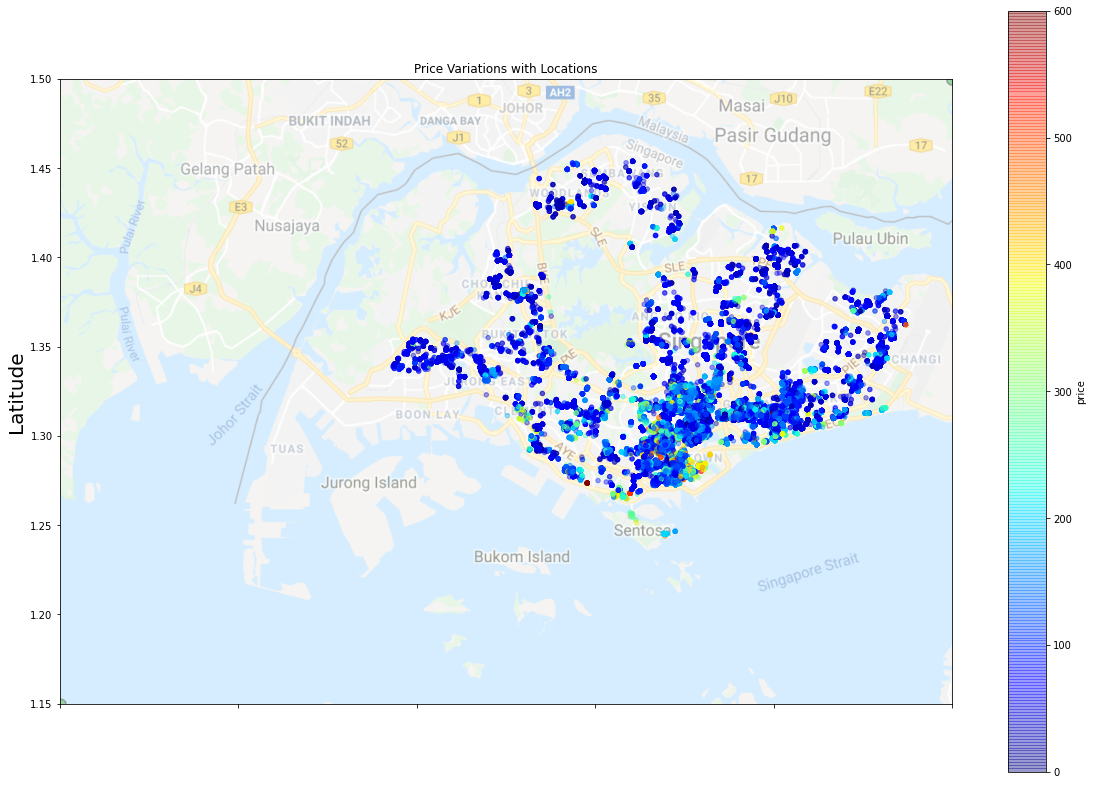

In [21]:
# Plot the relation of prices with geolocations
plotmap(df_cut, 'price')

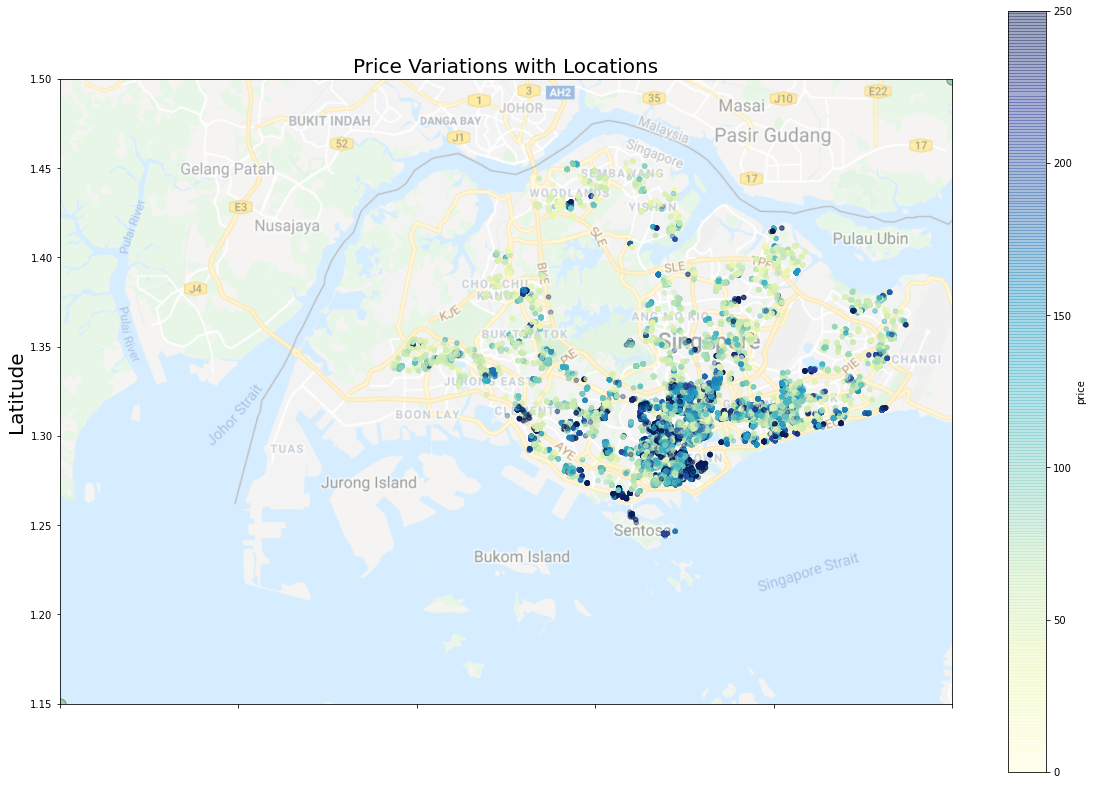

In [46]:
# Plot the relation of prices with geolocations (adjust the price to make plot clearer)
df_cut_1 = df_cut
df_cut_1['price'] = df_cut_1['price'].apply(lambda x: 250 if x > 250 else x)
plotmap(df_cut, 'price')

(array([16800., 47079., 26712., 18628.]),
 array([  0,  50, 100, 150, 200]),
 <a list of 4 Patch objects>)

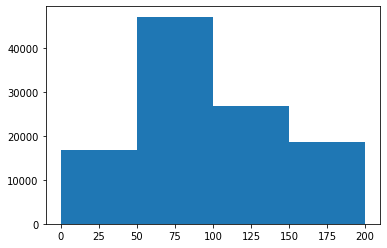

In [47]:
plt.hist(df_cut['price'], bins = [0, 50, 100, 150, 200])

In [48]:
shapefile = '../Pictures/2014-planning-area/MP14_PLNG_AREA_NO_SEA_PL.shp'
map_nbr = gpd.read_file(shapefile)

In [49]:
df_price_map = df_price_nbr.reset_index()
df_price_map.neighbourhood_cleansed = df_price_map.neighbourhood_cleansed.str.upper()

merge_map = map_nbr.merge(df_price_map, left_on='PLN_AREA_N', right_on='neighbourhood_cleansed')
merge_map.reset_index(inplace=True)

In [50]:
merge_map

,index,OBJECTID,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D,X_ADDR,...,neighbourhood_cleansed,price,senti_score,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,0,1,ANG MO KIO,AM,N,NORTH-EAST REGION,NER,E5CBDDE0C2113055,2016-05-11,28976.8763,...,ANG MO KIO,81.178054,0.812454,93.211180,9.546584,9.345756,9.933610,9.923395,9.033264,9.309129
1,1,2,BEDOK,BD,N,EAST REGION,ER,1719251260799DF6,2016-05-11,38582.6650,...,BEDOK,101.769992,0.801896,94.197680,9.663573,9.535189,9.789327,9.791802,9.357054,9.402692
2,2,3,BISHAN,BS,N,CENTRAL REGION,CR,BA616285F402846F,2016-05-11,28789.7630,...,BISHAN,77.039841,0.770622,92.428951,9.434263,9.236388,9.699867,9.657371,9.216467,9.282869
3,3,5,BUKIT BATOK,BK,N,WEST REGION,WR,FB44C870B04B7F57,2016-05-11,19255.4150,...,BUKIT BATOK,73.050699,0.765597,92.167832,9.395105,9.353147,9.649737,9.797203,9.047285,9.243433
4,4,6,BUKIT MERAH,BM,N,CENTRAL REGION,CR,738B479882E4EE28,2016-05-11,26865.7838,...,BUKIT MERAH,143.098242,0.783311,92.650694,9.558187,9.340241,9.719334,9.667345,9.508418,9.202035
5,5,7,BUKIT PANJANG,BP,N,WEST REGION,WR,4A9C6E6BAF7BE998,2016-05-11,21287.0436,...,BUKIT PANJANG,120.832090,0.757121,90.850746,9.354478,9.182836,9.436567,9.630597,8.996269,9.205224
6,6,8,BUKIT TIMAH,BT,N,CENTRAL REGION,CR,C893AEAD20F42559,2016-05-11,23256.7643,...,BUKIT TIMAH,89.406989,0.798908,92.889003,9.520308,9.279034,9.724422,9.768123,9.238560,9.343445
7,7,9,GEYLANG,GL,N,CENTRAL REGION,CR,957AC76DACFDE12E,2016-05-11,34255.0407,...,GEYLANG,116.542498,0.733152,91.319894,9.423702,9.150725,9.651790,9.675690,9.045566,9.121162
8,8,10,KALLANG,KL,N,CENTRAL REGION,CR,229F1481FF686959,2016-05-11,31685.3730,...,KALLANG,118.543617,0.736113,91.055526,9.370707,9.046968,9.631670,9.612038,9.369354,9.061922
9,9,11,NOVENA,NV,N,CENTRAL REGION,CR,916F55DE440B0D0E,2016-05-11,28221.5058,...,NOVENA,154.578598,0.740733,91.736162,9.322200,9.156458,9.574645,9.528967,9.276804,9.065707


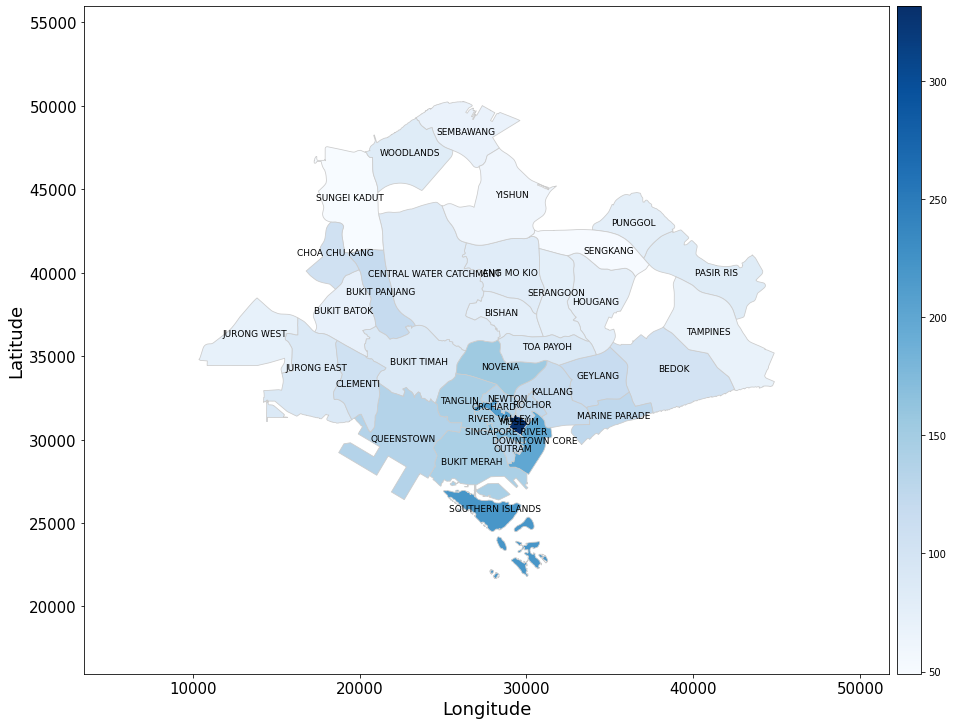

In [51]:
# Plot the map
fig, ax = plt.subplots(1, figsize = (15,25))

merge_map['coords'] = merge_map['geometry'].apply(lambda x:x.representative_point().coords[:])
merge_map['coords'] = [coords[0] for coords in merge_map['coords']]

for idx, row in merge_map.iterrows():
    plt.annotate(s=row['PLN_AREA_N'], xy=row['coords'], horizontalalignment='center',fontsize=9)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.1)

ax.margins(0.2,0.2)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

merge_map.plot(column='price',ax=ax,legend=True,cax=cax,cmap='Blues',linewidth=0.8,edgecolor='0.8')

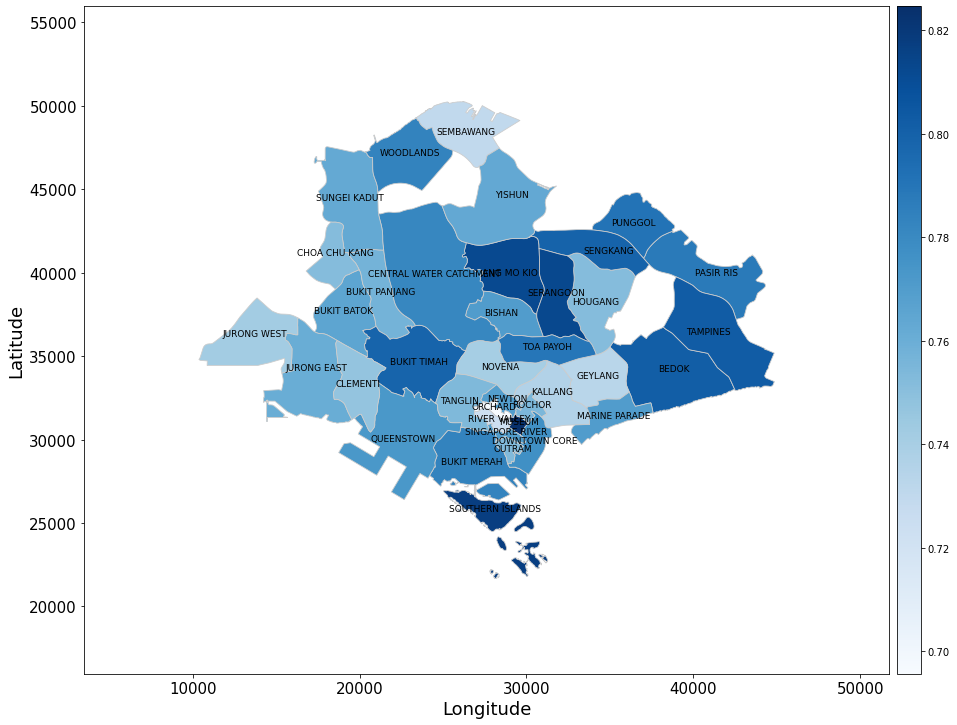

In [54]:
# Plot the map
fig, ax = plt.subplots(1, figsize = (15,25))

merge_map['coords'] = merge_map['geometry'].apply(lambda x:x.representative_point().coords[:])
merge_map['coords'] = [coords[0] for coords in merge_map['coords']]

for idx, row in merge_map.iterrows():
    plt.annotate(s=row['PLN_AREA_N'], xy=row['coords'], horizontalalignment='center',fontsize=9)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.1)

ax.margins(0.2,0.2)
ax.set_xlabel('Longitude', fontsize=18)
ax.set_ylabel('Latitude', fontsize=18)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

merge_map.plot(column='senti_score',ax=ax,legend=True,cax=cax,cmap='Blues',linewidth=0.8,edgecolor='0.8')